# PROJECT 6 

## AllLife Bank Customer Segmentation

## Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to compute distances
from scipy.spatial.distance import cdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

In [2]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

In [4]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [5]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

**The data looks to be complete with potentially no missing values or other trreatment required except for scaling**

In [8]:
# checking for missing values
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# There are no missing values found in the data

<IPython.core.display.Javascript object>

# EDA

## Univariate Analysis

In [10]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

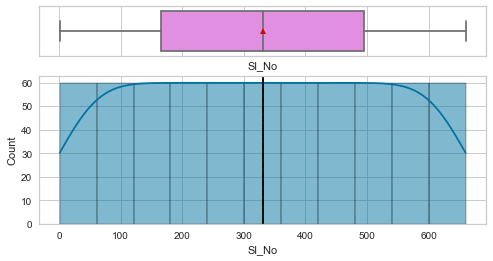

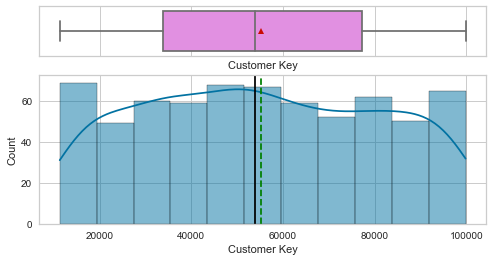

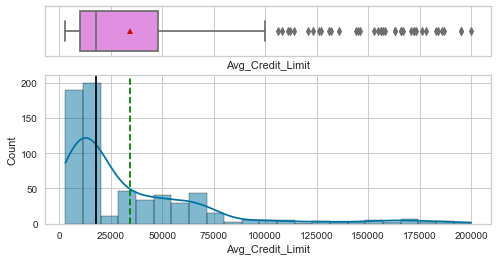

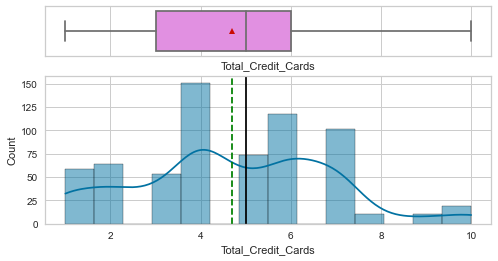

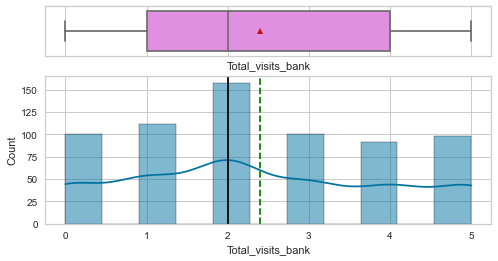

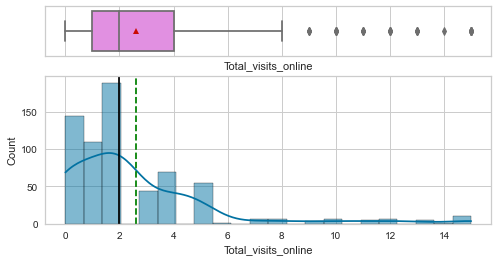

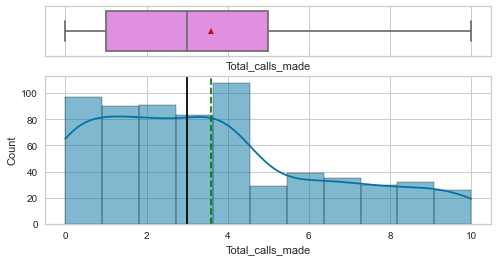

<IPython.core.display.Javascript object>

In [11]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(data, item, kde=True, figsize=(8, 4))

**Observations**

- The Sl No and Customer key parameters will not be considered for the initial kmeans clustering analsyis
- Total_calls_made are right skewed with a mean of 3.5 and a mode of 3.0
- Total_visits_online are right skewed with a mean of 2.6 and a median of 2.0
- Total_vists_bank looks to have a normal distributin with mean 2.4 and mode 2.0
- There is no identifiable distribution for Total_credit_cards with a mean of 4.7 and a mode of 5.0
- Average_credit_limit is right skwed with a mode of 18,000 and a mean 0f 34,574 with what it seems to be quite a few outliers


In [12]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

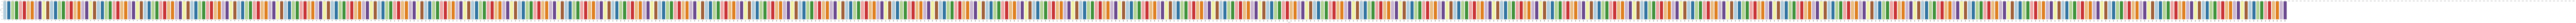

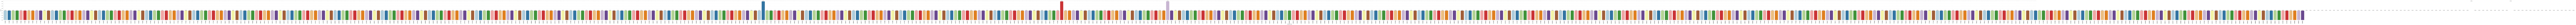

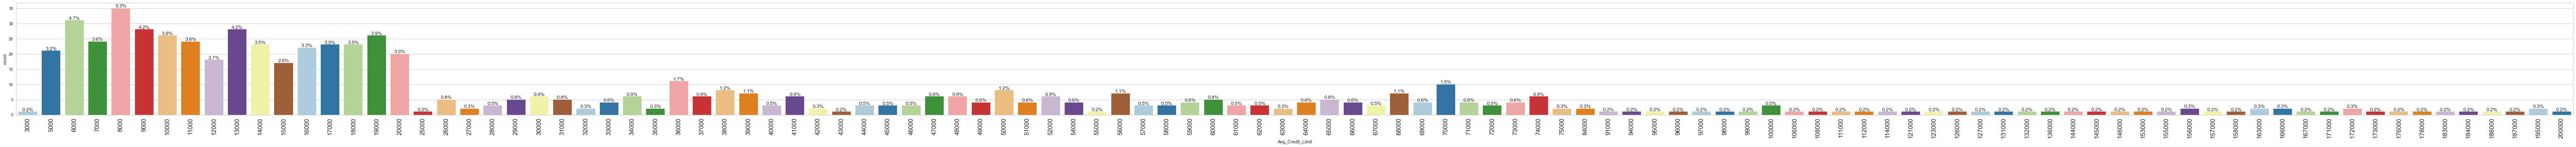

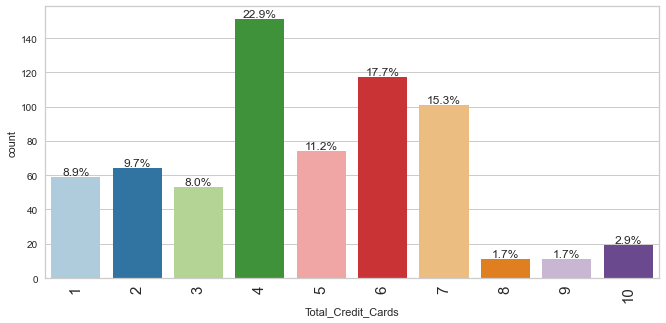

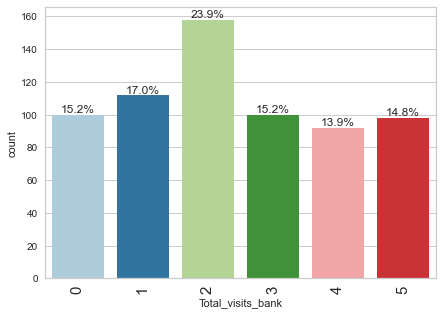

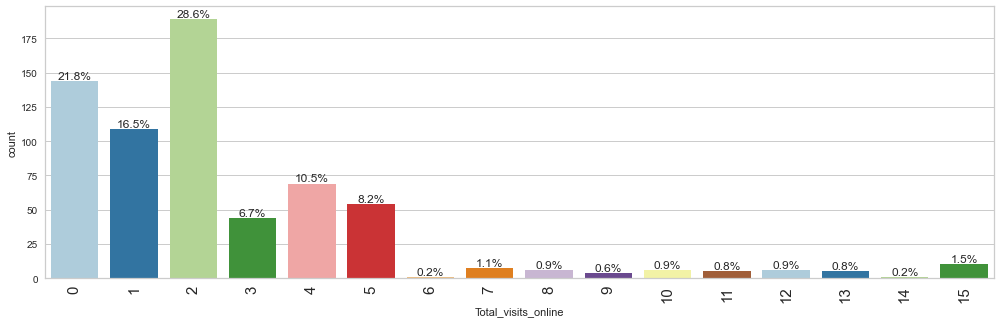

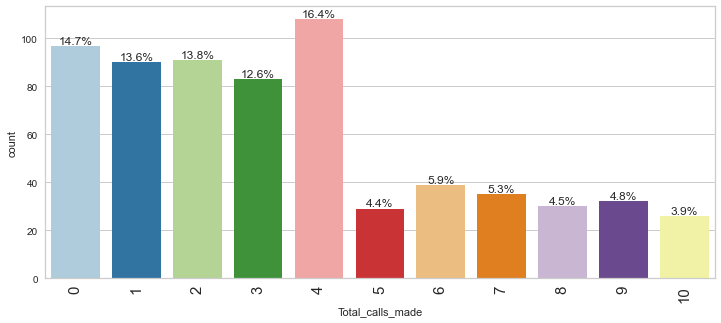

<IPython.core.display.Javascript object>

In [13]:
for item in num_col:
    labeled_barplot(data, item, perc=True)

**Observations**

- The largest percent of cutomers has 4 cards at 22% followed by 6 cards at 17% and 7 cards at 15%
- The highest percent of customer visits to the bank is 2 with 24%
- The highest percent of visits online is 2 at 29%
- The number of calls made is more or less uniform between 0 and 4 calls at an average 14% each and then drops to a an average of 5% from 5 to 10 calls made

### Bivariate Analsysis

**Checking correlations.**

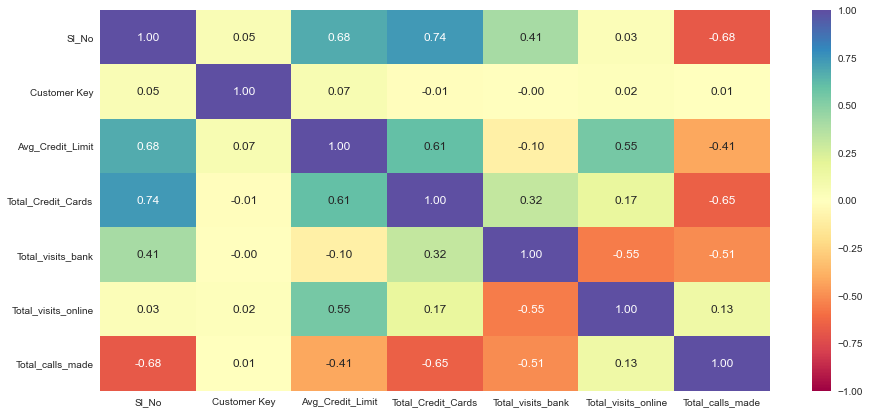

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(15, 7))
sns.heatmap(data[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

- There is some correlation between Sl_No (number of records) and Total_credit_cards. For clustering I will remove Sl_No as it doesn't provide any insights into clustering
- All other correlations are not higher than 0.7 or below -0.7 and of no concern we should treat them as independent variables

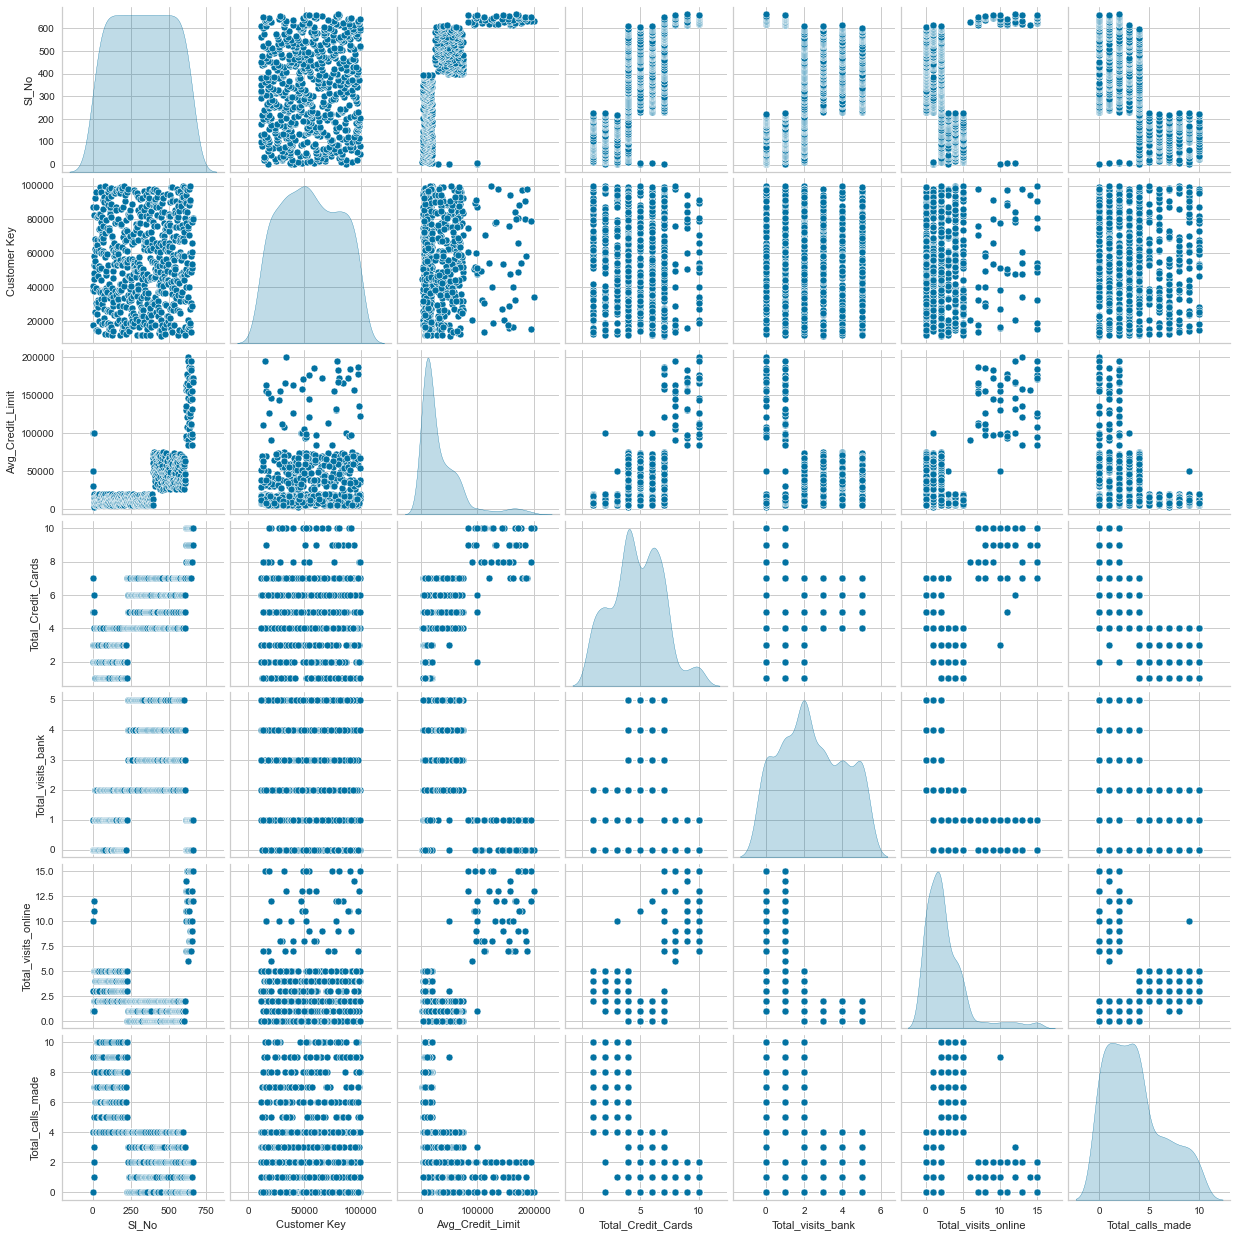

<IPython.core.display.Javascript object>

In [15]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- There is little to no indication of bi-modal distributions looking at the density plots


In [16]:
#Just checking on copy made at the beginning of the code to ensure I can go back to original values 
df.shape

(660, 7)

<IPython.core.display.Javascript object>

In [17]:
# dropping the Sl_No and Customer Key. columns it does not provide any information
df.drop(["Sl_No","Customer Key"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [18]:
df.shape

(660, 5)

<IPython.core.display.Javascript object>

In [23]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = data[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [24]:
#Checking scaled subset
subset_scaled

array([[-1.72942847,  1.24691971,  1.74018685, ..., -0.86045063,
        -0.54748969, -1.25153737],
       [-1.72417983, -0.65320273,  0.41029254, ..., -1.47373077,
         2.5205186 ,  1.89185881],
       [-1.71893118, -1.47609839,  0.41029254, ..., -0.86045063,
         0.13428993,  0.1455276 ],
       ...,
       [ 1.71893118, -0.05105538,  2.93709172, ..., -0.86045063,
         2.17962879, -0.90227113],
       [ 1.72417983,  0.99629832,  3.65523464, ..., -0.86045063,
         4.22496765, -1.25153737],
       [ 1.72942847,  0.97657819,  3.52224521, ..., -1.47373077,
         3.20229822, -0.55300488]])

<IPython.core.display.Javascript object>

In [25]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

In [26]:
subset_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,5.853903e-17,1.000758,-1.729428,-0.864714,0.000000,0.864714,1.729428
Customer Key,660.0,4.474535e-17,1.000758,-1.713365,-0.832392,-0.049474,0.861479,1.745585
Avg_Credit_Limit,660.0,8.195465e-16,1.000758,-0.839808,-0.653623,-0.440840,0.357097,4.399975
Total_Credit_Cards,660.0,-4.006223e-15,1.000758,-1.710864,-0.787585,0.135694,0.597334,2.443892
Total_visits_bank,660.0,1.157323e-16,1.000758,-1.473731,-0.860451,-0.247170,0.979390,1.592670
Total_visits_online,660.0,1.944572e-16,1.000758,-0.888380,-0.547490,-0.206600,0.475180,4.224968
Total_calls_made,660.0,-7.112156e-16,1.000758,-1.251537,-0.902271,-0.203739,0.494794,2.241125


<IPython.core.display.Javascript object>

In [27]:
#dropping the Sl_No column as it does not provide any information
subset_scaled_df.drop(["Sl_No","Customer Key"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [28]:
#Ensure that Sl_No and Customer key are not in the data set to be used for clustering
subset_scaled_df.shape

(660, 5)

<IPython.core.display.Javascript object>

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9907468928853334
Number of Clusters: 6 	Average Distortion: 0.9430693962124551
Number of Clusters: 7 	Average Distortion: 0.9104530271580018
Number of Clusters: 8 	Average Distortion: 0.8893571274402587


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

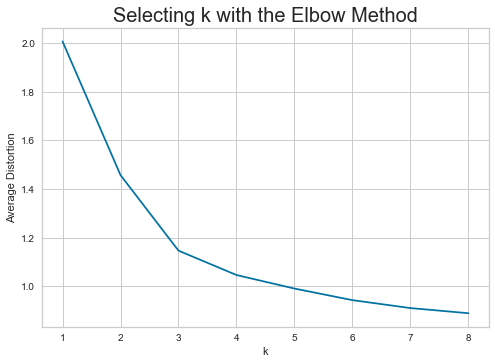

<IPython.core.display.Javascript object>

In [29]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 3 or 4.**

**Silhouette scores.**

For n_clusters = 2, silhouette score is 0.41842496663230405
For n_clusters = 3, silhouette score is 0.5157182558882754
For n_clusters = 4, silhouette score is 0.355667061937737
For n_clusters = 5, silhouette score is 0.2717470361094591
For n_clusters = 6, silhouette score is 0.2556644729193345
For n_clusters = 7, silhouette score is 0.24858998885001207
For n_clusters = 8, silhouette score is 0.22718813746336916
For n_clusters = 9, silhouette score is 0.22282431090278845


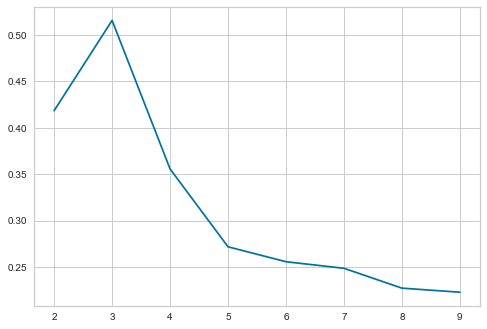

<IPython.core.display.Javascript object>

In [30]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.**

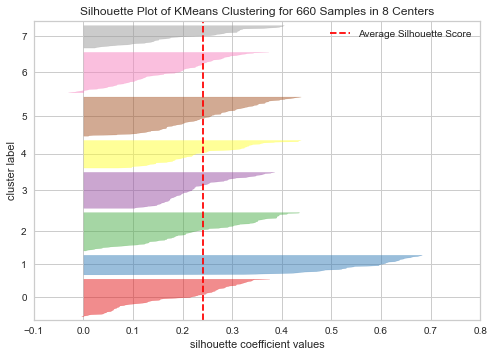

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [31]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

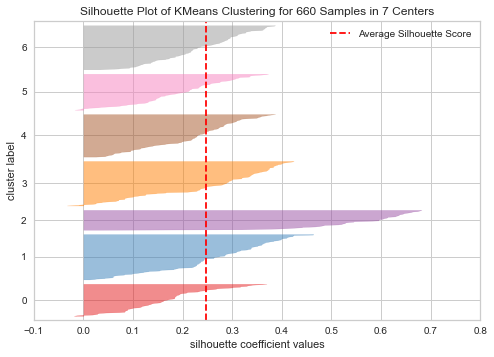

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [32]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

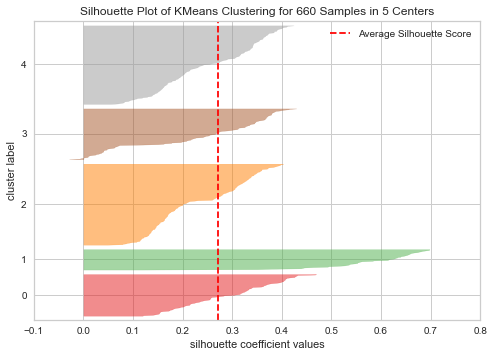

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [33]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

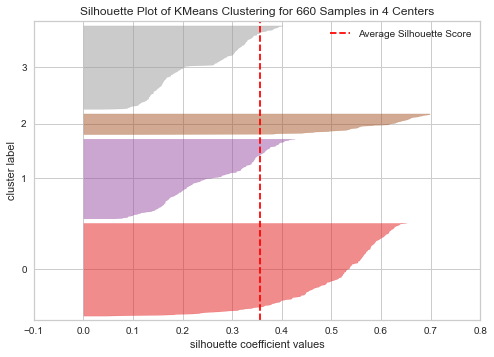

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [34]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

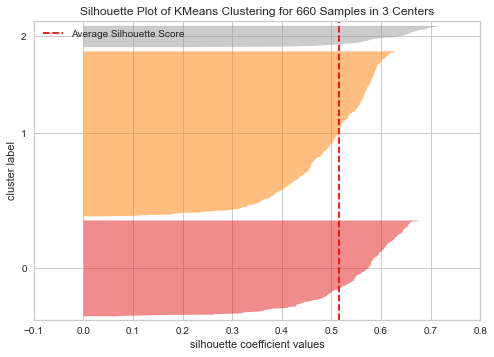

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [35]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

**Use 3 as the appropriate no. of clusters as the silhoutte score is highest and there is an inflection at 3 in the elbow curve.**

In [36]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

In [64]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [65]:
# adding kmeans cluster labels to the original dataframe
subset_scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [66]:
cluster_profile = subset_scaled_df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [67]:
cluster_profile["count_in_each_segment"] = (
    subset_scaled_df.groupby("K_means_segments")["Total_Credit_Cards"].count().values
)

<IPython.core.display.Javascript object>

In [68]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,-0.253717,0.011272,0.169922,-0.326813,-0.004032,397
1,-0.191844,-0.458152,-0.057140,-0.054560,0.212757,213
2,2.831764,1.862226,-1.105763,2.827319,-0.874330,50


<IPython.core.display.Javascript object>

In [69]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=0)

<IPython.core.display.Javascript object>

In [70]:
# adding kmeans cluster labels to the original dataframe
subset_scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [71]:
cluster_profile = subset_scaled_df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [72]:
cluster_profile["count_in_each_segment"] = (
    subset_scaled_df.groupby("K_means_segments")["Total_Credit_Cards"].count().values
)

<IPython.core.display.Javascript object>

In [73]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,-0.089048,0.356795,1.295713,-0.543901,-0.575064,190
1,-0.595515,-1.064153,-0.901888,0.329303,1.161861,222
2,2.831764,1.862226,-1.105763,2.827319,-0.874330,50
3,0.038056,0.380503,0.047080,-0.561263,-0.530073,198


<IPython.core.display.Javascript object>

In [48]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(random_state=0)

<IPython.core.display.Javascript object>

In [74]:
# adding kmeans cluster labels to the original dataframe
subset_scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [75]:
cluster_profile = subset_scaled_df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [76]:
cluster_profile["count_in_each_segment"] = (
    subset_scaled_df.groupby("K_means_segments")["Total_Credit_Cards"].count().values
)

<IPython.core.display.Javascript object>

In [52]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,,
0,113.548872,53047.285714,11992.481203,2.443609,0.984962,3.421053,5.511278,133
1,512.975000,60271.637500,52912.500000,5.825000,4.512500,0.825000,2.000000,80
2,609.541667,63801.625000,147833.333333,8.833333,0.500000,13.458333,1.083333,24
3,480.111111,56721.866667,57644.444444,5.433333,2.488889,0.955556,2.133333,90
4,344.372727,52400.536364,15454.545455,5.227273,4.518182,1.145455,1.890909,110
5,367.766355,52014.869159,18000.000000,5.635514,2.495327,0.962617,2.018692,107
6,122.044444,58291.966667,12500.000000,2.344444,0.844444,3.766667,8.911111,90
7,612.884615,50161.500000,134769.230769,8.653846,0.692308,8.538462,1.076923,26


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='K_means_segments'>

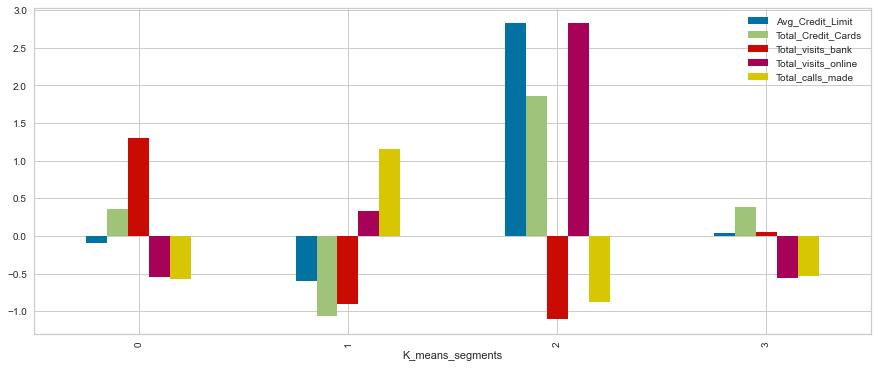

<IPython.core.display.Javascript object>

In [77]:
subset_scaled_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

### Insights

- **Cluster 0**:
- This cluster has the lowest average credit, low number of cards and moderate to high visits to the bank
 

- **Cluster 1**:
- This cluster has medium average credit, moderate amount of credit cards and high amount of calls made


- **Cluster 2**:

- This cluster has the highest average credit, highest number of cards and highest online vists to the bankc
   


### Hierarchical Clustering

In [80]:
data.shape

(660, 8)

<IPython.core.display.Javascript object>

In [82]:
list(data.columns)

['Sl_No',
 'Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made',
 'K_means_segments']

<IPython.core.display.Javascript object>

In [122]:
#reloading data to have a fresh copy 
data_h = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

In [123]:
data_h.shape

(660, 7)

<IPython.core.display.Javascript object>

In [125]:
#Removing record numbers before starting clustering
sc = StandardScaler()
subset_scaled_dframe_h = pd.DataFrame(
    sc.fit_transform(data_h.drop(["Sl_No", "Customer Key"], axis=1)),
    columns=data_h.drop(["Sl_No", "Customer Key"], axis=1).columns,
)
subset_scaled_dframe_h.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

In [137]:
data_h.shape

(660, 8)

<IPython.core.display.Javascript object>

In [139]:
list(data_h.columns)

['Sl_No',
 'Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made',
 'HC_Clusters']

<IPython.core.display.Javascript object>

In [126]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_dframe_h, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_dframe_h))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875362.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

<IPython.core.display.Javascript object>

In [127]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

### Using Euclidean Distance

In [128]:
# list of linkage methods for this analysis
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_dframe_h, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_dframe_h))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [129]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage and almost identical using centroid linkage.**

**Dendograms with different linkage methods.**

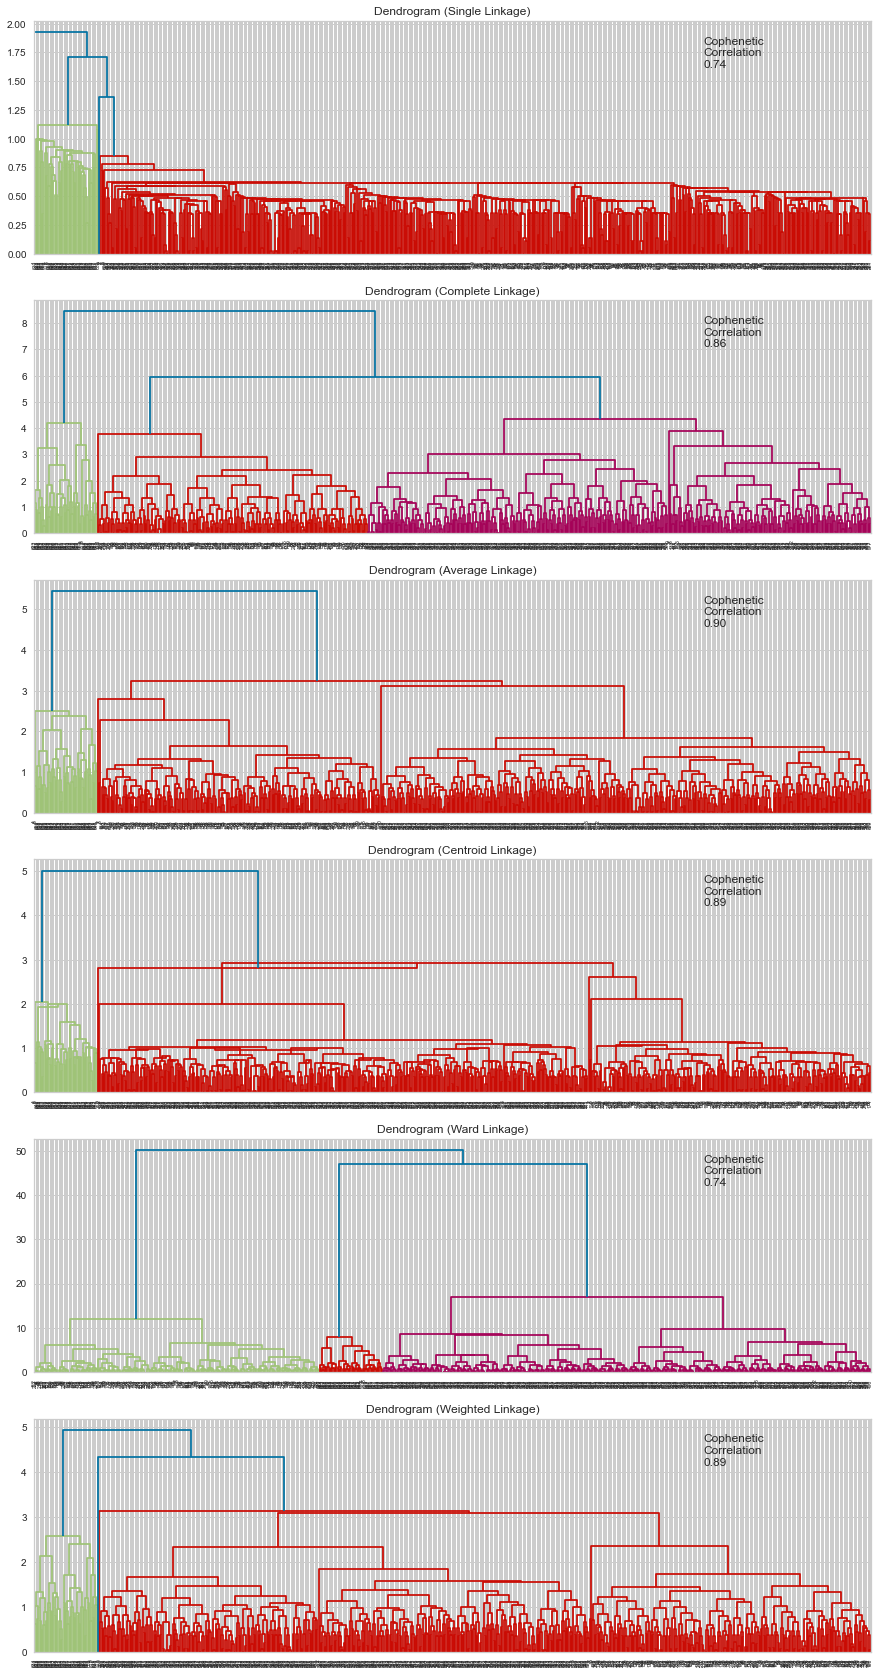

<IPython.core.display.Javascript object>

In [130]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_dframe_h, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_dframe_h))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average and centroid linkage methods.However, visually Ward linkage provides more clarity
- We will move ahead with average linkage.
- 3 appears to be the appropriate number of clusters from the dendrogram for ward linkage.


In [140]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_dframe_h)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [141]:
subset_scaled_dframe_h["HC_Clusters"] = HCmodel.labels_
data_h["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

In [154]:
data_h.shape

(660, 8)

<IPython.core.display.Javascript object>

In [155]:
cluster_profile = data_h.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [156]:
cluster_profile["count_in_each_segments"] = (
    data_h.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [157]:
 #lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,,,
0,417.260982,54925.966408,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,116.977578,55163.973094,12197.309417,2.403587,0.928251,3.560538,6.883408,223


<IPython.core.display.Javascript object>

In [158]:
data_h.shape

(660, 8)

<IPython.core.display.Javascript object>

In [159]:
list(data_h.columns)

['Sl_No',
 'Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made',
 'HC_Clusters']

<IPython.core.display.Javascript object>

In [161]:
list(subset_scaled_dframe_h.columns)

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made',
 'HC_Clusters']

<IPython.core.display.Javascript object>

## Insights

- Cluster 0 has the largest number of customers at 387 has the most visits to the bank and also has the least number of online visits. These customers have an average of 5.5 cards and a medium amount of average credit limit

- Cluster 1 has the largest credit limit and largest number of credit cards. This cluster visits the bank the least amount of times and tends to do their banking online with the highest number of online visits. This cluster also has the least amount of customers at 50

- Cluster 2 has the lowest number of credit cards at 2.5 the lowest credit limit with 12197, a moderate number of visits online at 3.5 but the highest number of calls at 6.87. There are 223 customers (approximate) in this cluster

### Recommendations

- There are three clear clusters that can be formed using both methods kmeans and hierarchical clustering
- Using the segmentation provided by the clusters, clients can be organized into the following categories
    - Customer segment a. Largest customer base with medium credit limits, medium number of credit cards that tend to bank personally and visit the bank
    - Customer segment b. Smallest customer base with high credit limits, high number of credit cards and tend to communicate online
    - Customer segment c. This group has the lowest number of credit cards and lowest credit limit and tends to communicate via phone
    
## Potential actions

- Target customer segment a to survey on bank services
- Target customer segment a form marketing campaigns at the bank
- On the same token as above target customer segment b for marketing campaigns online and customer segment c for phone campaigns

